# Consensus algorithm

In this example we'll show how to run a simple consensus algorithm.

## Background

We consider a network of `num_clients` peer clients. Each client $i$ maintains some local value $x_i^t$ and is connected to a subset of the other clients in the network, defined as the set of its neighbors $\mathcal{N}_i$.

The goal of all the clients is to reach consensus on their local values by communicating with their peers for a certain number of iterations $T$. 
In other terms, they want to cooperatively compute a weighted average of their initial values $x_i^0$.

The consensus algorithm works by having each client updating its local value as

$$x_i^{t+1} = \sum_{j\in\mathcal{N}_i}a_{ji}x_j^t$$

where $a_{ji}$ is the weight associated by client $i$ to client $j$ and $\sum_{j=1}^N a_{ji}=1$ for all $i$.

## Setup
Let's assume we have $N=5$ clients and generate a random configuration.

In [10]:
from nvdo.utils.config_generator import generate_random_network
from nvdo.types import Config

# generate random config
num_clients=5
network, adjacency_matrix = generate_random_network(num_clients=num_clients)
config = Config(network=network, extra={"iterations": 50})

By inspecting the config we can see the initial values of each client as well as the network topology.

In [11]:
from rich import print

print(config)

Config(
    network=Network(
        nodes=[
            Node(id='site-1', neighbors=[Neighbor(id='site-3', weight=0.3333333333333333)]),
            Node(
                id='site-2',
                neighbors=[
                    Neighbor(id='site-3', weight=0.3333333333333333),
                    Neighbor(id='site-4', weight=0.3333333333333333)
                ]
            ),
            Node(
                id='site-3',
                neighbors=[
                    Neighbor(id='site-1', weight=0.3333333333333333),
                    Neighbor(id='site-2', weight=0.3333333333333333)
                ]
            ),
            Node(
                id='site-4',
                neighbors=[
                    Neighbor(id='site-2', weight=0.3333333333333333),
                    Neighbor(id='site-5', weight=0.3333333333333333)
                ]
            ),
            Node(id='site-5', neighbors=[Neighbor(id='site-4', weight=0.3333333333333333)])
        ]
    ),
    extra={'iterations': 50}
)

## Instantiating and running the distributed algorithm

Now that we have all the configurations, we can instantiate the clients and a controller.

In [12]:
from nvflare.job_config.api import FedJob
from nvdo.executors import ConsensusExecutor
from nvdo.controllers import AlgorithmController

# Create job
job = FedJob(name="consensus")

# send controller to server
controller = AlgorithmController(config=config)
job.to_server(controller)

# Add clients
for i in range(num_clients):
    executor = ConsensusExecutor() # the executor will be initialized with a random value
    job.to(executor, f"site-{i+1}")

Finally, we can run the algorithm

In [13]:
# run
job.export_job("./tmp/job_configs")
job.simulator_run("./tmp/runs/consensus")

2025-01-29 09:52:48,639 - SimulatorRunner - INFO - Create the Simulator Server.
2025-01-29 09:52:48,642 - CoreCell - INFO - server: creating listener on tcp://0:52347
2025-01-29 09:52:48,681 - CoreCell - INFO - server: created backbone external listener for tcp://0:52347
2025-01-29 09:52:48,681 - ConnectorManager - INFO - 40803: Try start_listener Listener resources: {'secure': False, 'host': 'localhost'}
2025-01-29 09:52:48,682 - nvflare.fuel.f3.sfm.conn_manager - INFO - Connector [CH00002 PASSIVE tcp://0:12575] is starting
2025-01-29 09:52:49,183 - CoreCell - INFO - server: created backbone internal listener for tcp://localhost:12575
2025-01-29 09:52:49,183 - nvflare.fuel.f3.sfm.conn_manager - INFO - Connector [CH00001 PASSIVE tcp://0:52347] is starting
2025-01-29 09:52:49,184 - SimulatorServer - INFO - max_reg_duration=60.0
2025-01-29 09:52:49,214 - nvflare.fuel.hci.server.hci - INFO - Starting Admin Server localhost on Port 52348
2025-01-29 09:52:49,214 - SimulatorRunner - INFO - D

Now, since in this toy example we have access to both the intial values and the adjacency matrix, we can compute the consensus value at which the clients will converge.

In [14]:
import pickle
import torch

from nvdo.utils.topology import get_matrix_steady_state

history = {
    f"site-{i+1}": pickle.load(open(f"tmp/runs/consensus/site-{i+1}/results.pkl", "rb")) for i in range(num_clients)
}
x0=torch.tensor([h[0] for name, h in history.items()]).t()
consensus_value = x0 @ get_matrix_steady_state(adjacency_matrix)
print(f"Consensus value: {consensus_value}")

Consensus value: 0.5351105719804765

By inspecting the history/results, we can easily see that all the clients successfully converged to the expected consensus value. 

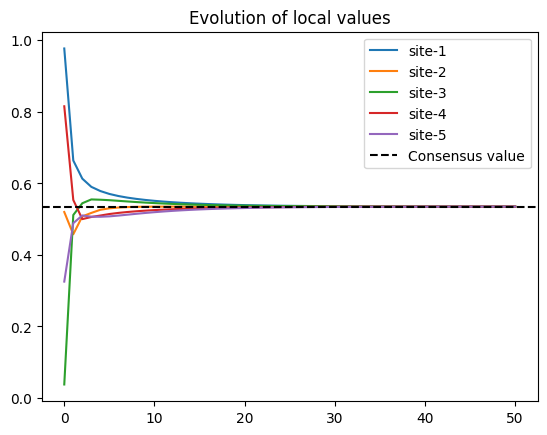

In [15]:
import matplotlib.pyplot as plt

# plot results
plt.figure()
for i in range(num_clients):
    plt.plot(history[f"site-{i+1}"], label=f"site-{i+1}")
plt.axhline(y=consensus_value, color='k', linestyle="--", label="Consensus value")
plt.legend()
plt.title("Evolution of local values")
plt.show()